# Step 1. Install required libraries

In [1]:
!apt install libasound2-dev portaudio19-dev libportaudio2 libportaudiocpp0 ffmpeg
!pip install PyAudio
!pip install pydub

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libasound2-dev is already the newest version (1.1.3-5ubuntu0.5).
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
Suggested packages:
  portaudio19-doc
The following NEW packages will be installed:
  libportaudio2 libportaudiocpp0 portaudio19-dev
0 upgraded, 3 newly installed, 0 to remove and 34 not upgraded.
Need to get 184 kB of archives.
After this operation, 891 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libportaudio2 amd64 19.6.0-1 [64.6 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libportaudiocpp0 amd64 19.6.0-1 [15.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 portaudio19-dev amd64 19.6.0-1 [104 kB]
Fetched 184 kB in 0s (1,177 kB/s)
Selecting 

# Step 2. Create models folder and download the latest emotion recognition model

In [2]:
!mkdir models
!mkdir working
!wget http://github.com/DeivisDervinis/EAPDA/raw/main/colab/models/audio.hdf5 -O models/audio.hdf5
!wget http://github.com/DeivisDervinis/EAPDA/raw/main/colab/models/testfile.json -O models/testfile.json


--2021-04-27 15:28:08--  http://github.com/DeivisDervinis/EAPDA/raw/main/colab/models/audio.hdf5
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/DeivisDervinis/EAPDA/raw/main/colab/models/audio.hdf5 [following]
--2021-04-27 15:28:08--  https://github.com/DeivisDervinis/EAPDA/raw/main/colab/models/audio.hdf5
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/DeivisDervinis/Speech-Emotion-Analyzer/raw/main/colab/models/audio.hdf5 [following]
--2021-04-27 15:28:08--  https://github.com/DeivisDervinis/Speech-Emotion-Analyzer/raw/main/colab/models/audio.hdf5
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/DeivisDervinis/Speech-Emoti

# Step 3. Upload audio files for Emotion Recognition

In [3]:
from google.colab import files

# Library for allowing to upload files locally
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

uploaded_file_name = list(uploaded.keys())[0]


Saving data_joined_sound_3.wav to data_joined_sound_3.wav
User uploaded file "data_joined_sound_3.wav" with length 1503310 bytes


# Step 4. Import libraries

In [4]:
## Basics ##
import time
import os
import numpy as np
## Audio Preprocessing ##
import pyaudio
import wave
import librosa
from scipy.stats import zscore

## Time Distributed CNN ##
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, TimeDistributed
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten
from tensorflow.keras.layers import LSTM

# Step 5. Load code for Emotion Recognition

In [5]:
class speechEmotionRecognition:

    ###
    ##Voice recording function
    ##

    def __init__(self, subdir_model=None):

        # Load prediction model
        if subdir_model is not None:
            self._model = self.build_model()
            self._model.load_weights(subdir_model)

        # Emotion encoding
        self._emotion = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Neutral', 5:'Sad', 6:'Surprise'}


    ### Computing Mel-Spectrogram
    def mel_spectrogram(self, y, sr=16000, n_fft=512, win_length=256, hop_length=128, window='hamming', n_mels=128, fmax=4000):

        # Compute spectogram
        mel_spect = np.abs(librosa.stft(y, n_fft=n_fft, window=window, win_length=win_length, hop_length=hop_length)) ** 2

        # Compute mel spectrogram
        mel_spect = librosa.feature.melspectrogram(S=mel_spect, sr=sr, n_mels=n_mels, fmax=fmax)

        # Compute log-mel spectrogram
        mel_spect = librosa.power_to_db(mel_spect, ref=np.max)

        return np.asarray(mel_spect)



    # Audio framing
    def frame(self, y, win_step=64, win_size=128):

        # Number of frames
        nb_frames = 1 + int((y.shape[2] - win_size) / win_step)

        # Framming
        frames = np.zeros((y.shape[0], nb_frames, y.shape[1], win_size)).astype(np.float16)
        for t in range(nb_frames):
            frames[:,t,:,:] = np.copy(y[:,:,(t * win_step):(t * win_step + win_size)]).astype(np.float16)

        return frames


    # Builds TDCNN
    def build_model(self):

        # Clear Keras session
        K.clear_session()

        # Define input
        input_y = Input(shape=(3, 128, 128, 1), name='Input_MELSPECT')

        # First LFLB (local feature learning block)
        y = TimeDistributed(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_1_MELSPECT')(input_y)
        y = TimeDistributed(BatchNormalization(), name='BatchNorm_1_MELSPECT')(y)
        y = TimeDistributed(Activation('elu'), name='Activ_1_MELSPECT')(y)
        y = TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'), name='MaxPool_1_MELSPECT')(y)
        y = TimeDistributed(Dropout(0.2), name='Drop_1_MELSPECT')(y)

        # Second LFLB (local feature learning block)
        y = TimeDistributed(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_2_MELSPECT')(y)
        y = TimeDistributed(BatchNormalization(), name='BatchNorm_2_MELSPECT')(y)
        y = TimeDistributed(Activation('elu'), name='Activ_2_MELSPECT')(y)
        y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'), name='MaxPool_2_MELSPECT')(y)
        y = TimeDistributed(Dropout(0.2), name='Drop_2_MELSPECT')(y)

        # Third LFLB (local feature learning block)
        y = TimeDistributed(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_3_MELSPECT')(y)
        y = TimeDistributed(BatchNormalization(), name='BatchNorm_3_MELSPECT')(y)
        y = TimeDistributed(Activation('elu'), name='Activ_3_MELSPECT')(y)
        y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'), name='MaxPool_3_MELSPECT')(y)
        y = TimeDistributed(Dropout(0.2), name='Drop_3_MELSPECT')(y)

        # Fourth LFLB (local feature learning block)
        y = TimeDistributed(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_4_MELSPECT')(y)
        y = TimeDistributed(BatchNormalization(), name='BatchNorm_4_MELSPECT')(y)
        y = TimeDistributed(Activation('elu'), name='Activ_4_MELSPECT')(y)
        y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'), name='MaxPool_4_MELSPECT')(y)
        y = TimeDistributed(Dropout(0.2), name='Drop_4_MELSPECT')(y)

        # Flat
        y = TimeDistributed(Flatten(), name='Flat_MELSPECT')(y)

        # LSTM layer
        y = LSTM(256, return_sequences=False, dropout=0.2, name='LSTM_1')(y)

        # Fully connected
        y = Dense(7, activation='softmax', name='FC')(y)

        # Build final model
        model = Model(inputs=input_y, outputs=y)

        return model



    # Predict speech emotion over time
    def predict_emotion_from_file(self, filename, chunk_step=16000, chunk_size=40000, predict_proba=False, sample_rate=16000):

        # Read audio file
        y, sr = librosa.core.load(filename, sr=sample_rate, offset=0.5)
        # Split audio signals into chunks
        chunks = self.frame(y.reshape(1, 1, -1), chunk_step, chunk_size)

        # Reshape chunks
        chunks = chunks.reshape(chunks.shape[1],chunks.shape[-1])

        # Z-normalization
        y = np.asarray(list(map(zscore, chunks)))

        # Compute mel spectrogram
        mel_spect = np.asarray(list(map(self.mel_spectrogram, y)))

        # Time distributed Framing
        mel_spect_ts = self.frame(mel_spect)

        # Build X for time distributed CNN
        X = mel_spect_ts.reshape(mel_spect_ts.shape[0],
                                    mel_spect_ts.shape[1],
                                    mel_spect_ts.shape[2],
                                    mel_spect_ts.shape[3],
                                    1)

        # Predict emotion
        if predict_proba is True:
            predict = self._model.predict(X)
        else:
            predict = np.argmax(self._model.predict(X), axis=1)
            predict = [self._emotion.get(emotion) for emotion in predict]


        # Clear Keras session
        K.clear_session()

        # Predict timestamp
        timestamp = np.concatenate([[chunk_size], np.ones((len(predict) - 1)) * chunk_step]).cumsum()
        timestamp = np.round(timestamp / sample_rate)

        return [predict, timestamp]



    #Export emotions
    def prediction_to_csv(self, predictions, filename, mode='w'):

        # Write emotion in filename
        with open(filename, mode) as f:
            if mode == 'w':
                f.write("EMOTIONS"+'\n')
            for emotion in predictions:
                f.write(str(emotion)+'\n')
            f.close()


# Step 6. Load the function that checks which emotion was present the most

In [6]:
from collections import Counter

 #Function that finds the most common occuring emotion
def find_state_emotion(listOfEmotions):
        
  count = Counter(listOfEmotions)
  max_val = max(count.values())
  return sorted(key for key, value in count.items() if value == max_val)
        

# Step 7. Run prediction on the loaded files

In [7]:
import json
import math
from pydub import AudioSegment
# Set model sub directory path
model_sub_dir = os.path.join('models', 'audio.hdf5')
emotion = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Neutral', 5:'Sad', 6:'Surprise'}

# Initialize SER object
SER = speechEmotionRecognition(model_sub_dir)

# Create an empty segment emotion list to store emotions
segmentEmoList = []

# Create a list of timestamps
timestampList = []
timestampCounter = 3


# Create an empty final emotion list for tracking emotions through segments
finalEmoList = []

# List of state flags
stateFlagList = [0,0,0,0,0,0,0]

# Create an emotion found flag to check if the final emotion was found or not
isFirstStateFound = False
isFirstStateEncountered = False

# Create an empty string for final emotion
finalEmotion = ""
stateEmotion = ""

# Set the name of the audio file
#audio_file_name = os.path.join("data","joined_sound_7.wav")
audio_file_name = uploaded_file_name

# Sets the duration of audio
audio_duration = math.floor(librosa.get_duration(filename=audio_file_name))

# Pritns the duration of the audio
print("The duration of audio is: " +str(audio_duration))
# Starting slice and end slice values
n = 0
nSpan = 3

# List of sliced segments
listOfSegNames = []

for i in range(0, (audio_duration + 1) - nSpan):   
    t1 = n * 1000
    t2 = (n + nSpan) * 1000
    
    # Select audio file to segment
    oldAudio = AudioSegment.from_wav(audio_file_name)

    # Create a segment of 3 seconds from old audio file
    newAudio = oldAudio[t1:t2]

    # Save new segment name
    seg_name = "working/seg_" + str(n) + "_" +str((n+nSpan)) +".wav"

    # Append segment name to a list for later use
    listOfSegNames.append(seg_name)
    
    # Export segment to its own individual file
    newAudio.export(seg_name, format="wav")

    # Slide the selected second slider by one   
    n += 1

# Run prediction for each segment
for k in range(0, len(listOfSegNames)):
    # Select the segment from the list of saved segment names
    rec_sub_dir = listOfSegNames[k]
    
    # Predict emotion in voice at each time step
    step = 1 # in sec
    sample_rate = 16000 # in kHz
    emotions, timestamp = SER.predict_emotion_from_file(rec_sub_dir, chunk_step=step*sample_rate)

    # Append emotion of the segment to a list
    maxValEmo = max(set(emotions), key=emotions.count)
    segmentEmoList.append(maxValEmo)

    # Check states after the initial state
    if isFirstStateFound == True:
      timestampCounter += 1

      # Determine the state of the emotion
      stateEmotion = max(set(emotions), key=emotions.count)

      # Find the index for the determined emotion
      stateIndex = list(emotion.keys())[list(emotion.values()).index(stateEmotion)]

      # Increment by 1 for the state that appears
      stateFlagList[stateIndex] += 1

      # Check if any of the states (Emotions) occurs 3 times
      if stateFlagList[stateIndex] == 3:
        # Get the emotion by the index
        stateEmotion = emotion.get(stateIndex)

        # Append the emotion to the final emotion list
        finalEmoList.append([stateEmotion])

        timestampList.append(timestampCounter)

        # Reset the state (emotion) occurance list to zero
        stateFlagList = [0,0,0,0,0,0,0]
        timestampCounter = 0

    # Set the initial state emotion
    if len(segmentEmoList) > 2 and isFirstStateFound == False:
      # Call function to determine emotion
      firstState = find_state_emotion(segmentEmoList)
      #print(firstState)
      if len(firstState) == 1:
        # Add the segment emotion to the list
        finalEmoList.append(firstState)
        timestampCounter += 2
        timestampList.append(timestampCounter)
        timestampCounter = 0
        isFirstStateFound = True
      else:
        timestampCounter += 1
      

# Prints for debugging
print(segmentEmoList)
print(timestampList)

if sum(timestampList) != audio_duration:
  timestampList[-1] = timestampList[-1] + (audio_duration - sum(timestampList))

print(timestampList)
# Create an empty list to store unhashedList
unhashedList = []

# Unhashes a list for readability
for item in finalEmoList:
  unhashedList.append(item[0])

# Check if there is a majority for the segments
print(unhashedList)
return_emotion = find_state_emotion(unhashedList)
print(return_emotion)

# If there is no majority therefore the emotion is neutral
if len(return_emotion) != 1:
  print("Majority doesn't win")
  print("The emotion is: Neutral")
else:
  # If there is a majority then print the emotion
  print("Majority wins")
  print("The emotion is: " + str(return_emotion[0]))
  del timestampList[:]
  timestampList.append(audio_duration)

# Code for removing the segments
for segment in listOfSegNames:
  !rm $segment
print("Previous segments removed")


The duration of audio is: 17
['Disgust', 'Surprise', 'Angry', 'Angry', 'Happy', 'Happy', 'Fear', 'Happy', 'Surprise', 'Disgust', 'Neutral', 'Neutral', 'Fear', 'Fear', 'Fear']
[6, 4, 7]
[6, 4, 7]
['Angry', 'Happy', 'Fear']
['Angry', 'Fear', 'Happy']
Majority doesn't win
The emotion is: Neutral
Previous segments removed


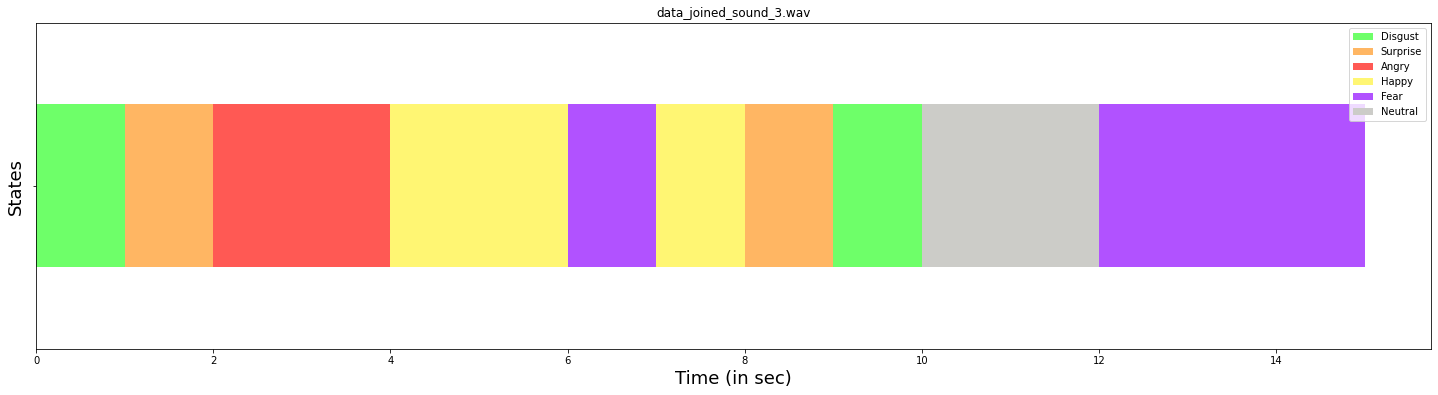

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

colorDict = {'Angry':"#ff5954",'Disgust':"#6eff69", 'Fear':"#b152ff", 'Happy': '#fff673', 'Neutral':'#ccccc8', 'Sad':'#5c8dff', 'Surprise':'#ffb663'}
colorList = []

df = pd.DataFrame({}, index=[0])
counter = 0
for item in segmentEmoList:
  df.insert(counter, item, 1, True)
  counter += 1
  colorList.append(colorDict.get(item))

ax = df.plot.barh(stacked=True, color=colorList)


ax.figure.set_size_inches(25,6)
ax.set_xlabel('Time (in sec)', fontsize=18)
ax.set_ylabel('States', fontsize=18)
ax.set_yticklabels([])

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))

ax.set_title(audio_file_name)
ax.legend(by_label.values(), by_label.keys())

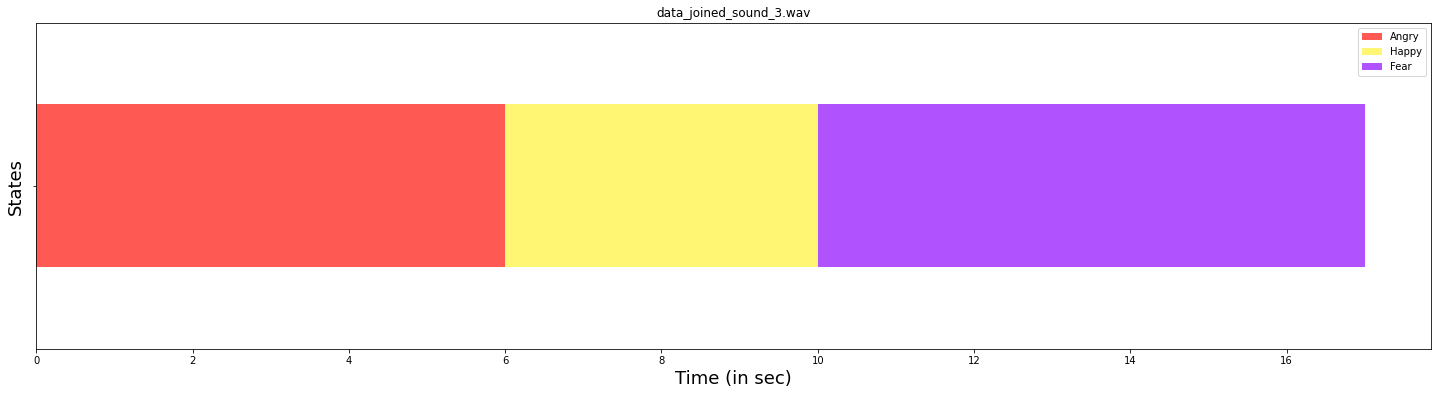

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

colorDict = {'Angry':"#ff5954",'Disgust':"#6eff69", 'Fear':"#b152ff", 'Happy': '#fff673', 'Neutral':'#ccccc8', 'Sad':'#5c8dff', 'Surprise':'#ffb663'}
colorList = []

df = pd.DataFrame({}, index=[0])
counter = 0

if len(unhashedList) == len(timestampList):
  for index in unhashedList:
    df.insert(counter, index, timestampList[counter], True)
    counter += 1
    colorList.append(colorDict.get(index))
else:
  df.insert(0, return_emotion[0], timestampList[0], True)
  colorList.append(colorDict.get(return_emotion[0]))

ax = df.plot.barh(stacked=True, color=colorList)


ax.figure.set_size_inches(25,6)
ax.set_xlabel('Time (in sec)', fontsize=18)
ax.set_ylabel('States', fontsize=18)
ax.set_yticklabels([])

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))

ax.set_title(audio_file_name)
ax.legend(by_label.values(), by_label.keys())

trigger
trigger
trigger
[6, 4, 7]
Accuracy of Angry: 35.294117647058826%
Accuracy of Fear: 41.17647058823529%
Accuracy of Happy: 23.52941176470588%


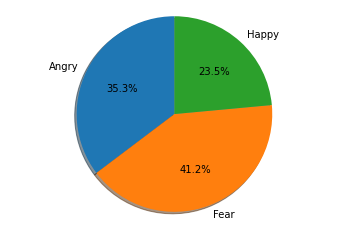

In [20]:
# Metrics

segmentEmoDuration = {'Angry':0,'Disgust':0, 'Fear':0, 'Happy': 0, 'Neutral':0, 'Sad':0, 'Surprise':0}

counter = audio_duration
labels = []
sizes = []

index = 0

for item in unhashedList:
  if item in segmentEmoDuration:
    segmentEmoDuration[item] = timestampList[index]
    index += 1

for emotion in segmentEmoDuration:
  if segmentEmoDuration.get(emotion) > 0:
    accuracy = (segmentEmoDuration.get(emotion) / counter) * 100
    labels.append(emotion)
    sizes.append(accuracy)
    print("Accuracy of " +emotion +": " +str(accuracy) +"%")

fig2, ax2 = plt.subplots()
ax2.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax2.axis('equal')
plt.show()